Setting Backend To: AvailableBackends.numpy


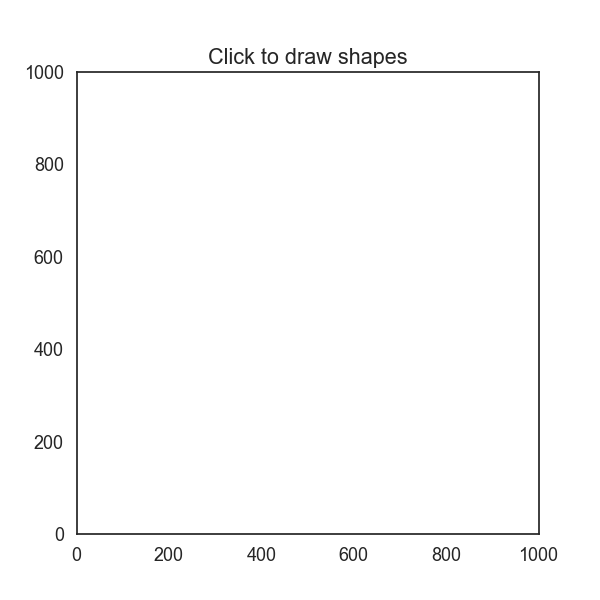

Named the last drawn line: rock2
Named the last drawn line: rock1
Named the last drawn line: rock3
Named the last drawn line: rock3
Named the last drawn line: rock4
Named the last drawn line: rock4
Named the last drawn line: fault1


In [1]:
!pip install ipywidgets
!pip install ipympl


# Set matplotlib to widget mode
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import ipywidgets as widgets
from IPython.display import display
import gempy as gp
import gempy_viewer as gpv

class InteractiveDrawingApp:
    def __init__(self):
        self.mode = "line"  # Initial drawing mode
        self.fig, self.ax = plt.subplots(figsize=(6, 6))  # Fixed canvas size
        self.ax.set_xlim(0, 1000)
        self.ax.set_ylim(0, 1000)
        self.ax.set_aspect('equal')  # Keep axis proportions equal

        self.current_line = None  # Current drawing line
        self.lines = []  # Store completed line objects and coordinates
        self.all_points = []  # Store all line coordinates in a unified list
        self.line_names = []  # Store line names
        self.curve_points = []  # Store curve points temporarily
        self.start_point = None  # Starting point for a straight line

        # Buttons and input fields
        self.line_button = widgets.Button(description="Line Mode")
        self.curve_button = widgets.Button(description="Curve Mode")
        self.clear_button = widgets.Button(description="Clear Canvas")
        self.undo_button = widgets.Button(description="Undo")
        self.get_data_button = widgets.Button(description="Get Data")
        self.line_name_input = widgets.Text(description="Line Name:", placeholder="Enter line name")
        self.save_name_button = widgets.Button(description="Save Name")

        # Display buttons and inputs
        display(widgets.HBox([self.line_button, self.curve_button, self.clear_button, self.undo_button, self.get_data_button]))
        display(widgets.HBox([self.line_name_input, self.save_name_button]))

        # Bind button events
        self.line_button.on_click(self.set_line_mode)
        self.curve_button.on_click(self.set_curve_mode)
        self.clear_button.on_click(self.clear_canvas)
        self.undo_button.on_click(self.undo_last_line)
        self.get_data_button.on_click(self.get_curve_data)
        self.save_name_button.on_click(self.save_line_name)

        # Configure canvas
        self.ax.set_title("Click to draw shapes")
        self.fig.canvas.mpl_connect("button_press_event", self.on_click)
        self.fig.canvas.mpl_connect("motion_notify_event", self.on_drag)
        self.fig.canvas.mpl_connect("button_release_event", self.on_release)

        plt.show()

    def set_line_mode(self, event):
        self.mode = "line"
        self.curve_points = []
        self.start_point = None
        self.ax.set_title("Line Mode")
        self.fig.canvas.draw_idle()

    def set_curve_mode(self, event):
        self.mode = "curve"
        self.curve_points = []
        self.start_point = None
        self.ax.set_title("Curve Mode")
        self.fig.canvas.draw_idle()

    def clear_canvas(self, event):
        self.ax.clear()
        self.ax.set_xlim(0, 1000)  # Reset canvas
        self.ax.set_ylim(0, 1000)
        self.lines = []
        self.all_points = []  # Clear stored point data
        self.line_names = []  # Clear line names
        self.curve_points = []
        self.start_point = None
        self.current_line = None
        self.ax.set_title("Click to draw shapes")
        self.fig.canvas.draw_idle()

    def undo_last_line(self, event):
        if self.lines:
            last_line = self.lines.pop()  # Remove the last completed line
            self.all_points.pop()  # Remove from the unified points list
            self.line_names.pop()  # Remove from the names list
            line_obj = last_line["line"]
            line_obj.remove()  # Remove the last line from the canvas
            self.fig.canvas.draw_idle()

    def save_line_name(self, event):
        if not self.lines:
            print("No lines available for naming!")
            return
        line_name = self.line_name_input.value.strip()
        if line_name:
            self.line_names[-1] = line_name
            print(f"Named the last drawn line: {line_name}")
        else:
            print("Please enter a valid line name!")

    def get_curve_data(self, event):
        if not self.all_points:
            print("No data available!")
            return

        print("All line data:")
        for i, points in enumerate(self.all_points):
            x_data, y_data = zip(*points)
            gradients = np.gradient(y_data, x_data)
            line_name = self.line_names[i] if i < len(self.line_names) else f"Line {i+1}"
            print(f"{line_name}:")
            print(f"Coordinates (x, y): {points}")
            print(f"Gradients: {gradients}\n")

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        if self.mode == "line":
            self.start_point = (event.xdata, event.ydata)
        elif self.mode == "curve":
            self.curve_points = [(event.xdata, event.ydata)]

    def on_drag(self, event):
        if event.inaxes != self.ax:
            return
        if self.mode == "line" and self.start_point:
            if self.current_line:
                self.current_line.remove()  # Remove the current dynamic line
            self.current_line, = self.ax.plot(
                [self.start_point[0], event.xdata],
                [self.start_point[1], event.ydata],
                color="black",
            )
        elif self.mode == "curve":
            if self.curve_points:
                self.curve_points.append((event.xdata, event.ydata))
                x, y = zip(*self.curve_points)
                if self.current_line:
                    self.current_line.remove()  # Remove the current dynamic line
                self.current_line, = self.ax.plot(x, y, color="black")
        self.fig.canvas.draw_idle()

    def on_release(self, event):
        if event.inaxes != self.ax:
            return
        if self.mode == "line" and self.start_point:
            if self.current_line:
                x_data = [self.start_point[0], event.xdata]
                y_data = [self.start_point[1], event.ydata]
                points = list(zip(x_data, y_data))
                self.lines.append({"line": self.current_line, "x": x_data, "y": y_data})
                self.all_points.append(points)  # Save to unified points list
                self.line_names.append("Unnamed Line")  # Default name
                self.current_line = None
            self.start_point = None
        elif self.mode == "curve":
            if self.current_line:
                x, y = zip(*self.curve_points)
                points = list(zip(x, y))
                self.lines.append({"line": self.current_line, "x": list(x), "y": list(y)})
                self.all_points.append(points)  # Save to unified points list
                self.line_names.append("Unnamed Curve")  # Default name
                self.current_line = None
            self.curve_points = []

# Create a global instance of the application
drawing_app = InteractiveDrawingApp()


### Data converter

In [41]:
import pandas as pd
import numpy as np

def process_drawing_data(drawing_app):
    # List to store processed data
    processed_data = []

    # Iterate over all points and their corresponding names
    for points, name in zip(drawing_app.all_points, drawing_app.line_names):
        x_coords = np.array([p[0] for p in points])
        z_coords = np.array([p[1] for p in points])  # z corresponds to y in drawing

        # Process lines (two points)
        if len(points) == 2:
            # Interpolate to 10 points
            x_coords = np.linspace(x_coords[0], x_coords[1], 10)
            z_coords = np.linspace(z_coords[0], z_coords[1], 10)

        # Process curves (more than two points)
        elif len(points) > 2:
            # Limit to 15 points by downsampling
            indices = np.round(np.linspace(0, len(points) - 1, min(15, len(points)))).astype(int)
            x_coords = x_coords[indices]
            z_coords = z_coords[indices]

        # Repeat x and z coordinates for three y-planes: 0, 500, 1000
        y_planes = [0, 500, 1000]
        for y in y_planes:
            for x, z in zip(x_coords, z_coords):
                processed_data.append([x, y, z, name])

    # Create DataFrame
    df = pd.DataFrame(processed_data, columns=["X", "Y", "Z", "formation"])
    return df

# Function to calculate orientation (gradient in 2D)
def cal_orientation(x, y):
    x1 = y[1] - x[1]
    y1 = y[0] - x[0]
    norm = np.sqrt(x1 ** 2 + y1 ** 2)
    return x1 / norm, y1 / norm

def process_drawing_with_gradients(drawing_app):
    # List to store processed data with gradients
    gradient_data = []

    # Iterate over all points and their corresponding names
    for points, name in zip(drawing_app.all_points, drawing_app.line_names):
        x_coords = np.array([p[0] for p in points])
        z_coords = np.array([p[1] for p in points])  # z corresponds to y in drawing

        # Process lines (two points)
        if len(points) == 2:
            # Interpolate to 10 points
            x_coords = np.linspace(x_coords[0], x_coords[1], 10)
            z_coords = np.linspace(z_coords[0], z_coords[1], 10)

        # Process curves (more than two points)
        elif len(points) > 2:
            # Limit to 15 points by downsampling
            indices = np.round(np.linspace(0, len(points) - 1, min(15, len(points)))).astype(int)
            x_coords = x_coords[indices]
            z_coords = z_coords[indices]

        # Calculate gradients for each segment
        G_x, G_z = [], []
        for i in range(len(x_coords) - 1):
            gx, gz = cal_orientation([x_coords[i], z_coords[i]], [x_coords[i + 1], z_coords[i + 1]])
            G_x.append(gx)
            G_z.append(gz)

        # Repeat the last gradient for consistent length
        G_x.append(G_x[-1])
        G_z.append(G_z[-1])

        # Repeat x, z, gradients for three y-planes: 0, 500, 1000
        y_planes = [0, 500, 1000]
        for y in y_planes:
            for x, z, gx, gz in zip(x_coords, z_coords, G_x, G_z):
                gradient_data.append([x, y, z, name, -gx, 0, gz])

    # Create DataFrame
    df = pd.DataFrame(gradient_data, columns=["x", "y", "z", "formation", "G_x", "G_y", "G_z"])
    return df

# Process the data with gradients

# Process the data
df = process_drawing_data(drawing_app)
df_with_gradients = process_drawing_with_gradients(drawing_app)


df.to_csv("Generated data/Surface_points.csv")
df_with_gradients.to_csv("Generated data/Orientations.csv")

### Build GemPy model

In [42]:
geo_model: gp.data.GeoModel = gp.create_geomodel(
        project_name='Model',
        extent=[0, 1000, 0, 1000, 0, 1000],
        resolution = [25, 25, 25], 
        importer_helper=gp.data.ImporterHelper(
        path_to_orientations="Generated data/Orientations.csv",
        path_to_surface_points="Generated data/Surface_points.csv",
        )
        )

In [43]:
geo_model.input_transform.apply_anisotropy(gp.data.GlobalAnisotropy.NONE)

gp.add_structural_group(
    model=geo_model,
    group_index=0,
    structural_group_name="fault_series",
    elements=[geo_model.structural_frame.get_element_by_name("fault1")],
    structural_relation=gp.data.StackRelationType.FAULT
)

gp.add_structural_group(
    model=geo_model,
    group_index=1,
    structural_group_name="seafloor_series",
    elements=[geo_model.structural_frame.get_element_by_name("rock1"),
              ],
    structural_relation=gp.data.StackRelationType.ONLAP,
)

gp.add_structural_group(
    model=geo_model,
    group_index=2,
    structural_group_name="seafloor_series",
    elements=[
              geo_model.structural_frame.get_element_by_name("rock2"),],
    structural_relation=gp.data.StackRelationType.ERODE,
)

gp.add_structural_group(
    model=geo_model,
    group_index=3,
    structural_group_name="eroded_series",
    elements=[geo_model.structural_frame.get_element_by_name("rock3")],
    structural_relation=gp.data.StackRelationType.ERODE
)


gp.add_structural_group(
    model=geo_model,
    group_index=4,
    structural_group_name="base_series",
    elements=[geo_model.structural_frame.get_element_by_name("rock4")],
    structural_relation=gp.data.StackRelationType.ERODE
)
gp.remove_structural_group_by_name(model=geo_model, group_name="default_formation")
geo_model.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=fault_series,
	structural_relation=StackRelationType.FAULT,
	elements=[
Element(
	name=fault1,
	color=#015482,
	is_active=True
)
]
),
StructuralGroup(
	name=seafloor_series,
	structural_relation=StackRelationType.ONLAP,
	elements=[
Element(
	name=rock1,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=seafloor_series,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=rock2,
	color=#ffbe00,
	is_active=True
)
]
),
StructuralGroup(
	name=eroded_series,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=rock3,
	color=#728f02,
	is_active=True
)
]
),
StructuralGroup(
	name=base_series,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=rock4,
	color=#443988,
	is_active=True
)
]
)
],
	fault_relations=
[[False,  True,  True,  True,  True],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False]],

In [22]:
# from gempy_engine.core.data.stack_relation_type import StackRelationType
# gp.map_stack_to_surfaces(
#     gempy_model=geo_model,
#     mapping_object={
#         "Strat_Series1": ('rock1', 'rock2'),
#         "Strat_Series2": ('rock3'),
#         "Fault_Series1" : ('fault1'),
#         "Strat_Series3": ('rock4'),
#     }
# )
# geo_model.structural_frame.structural_groups[2].structural_relation = StackRelationType.FAULT

# geo_model.structural_frame.fault_relations = np.array(
#     [[0, 0, 0, 0],
#      [0, 0, 0, 0],
#      [0, 0, 0, 1],
#      [0, 0, 0, 0],])

# geo_model.structural_frame

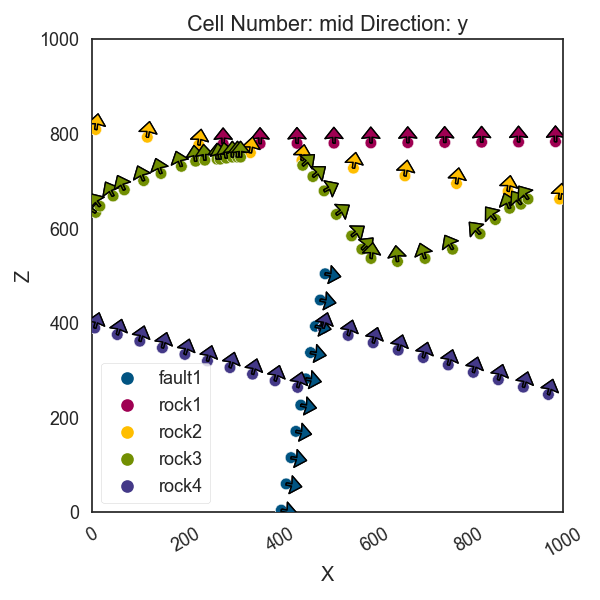

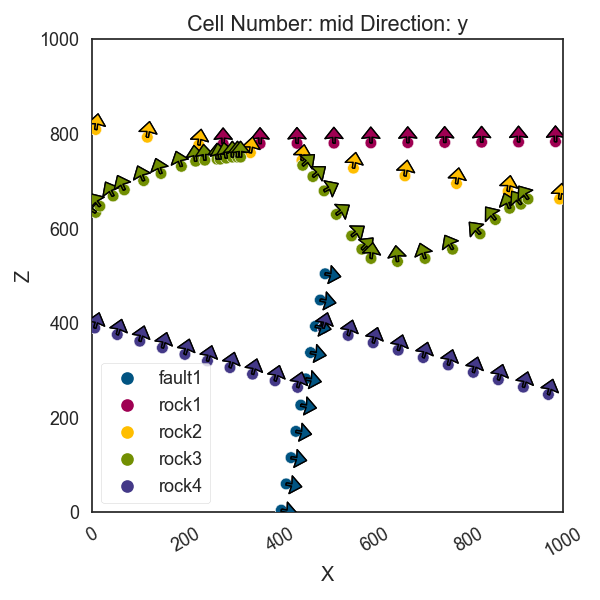

In [44]:
gpv.plot_2d(geo_model, direction=['y'], show_results=False, figsize=(6,6))

In [18]:
gpv.plot_3d(geo_model)

In [45]:
from gempy_engine.config import AvailableBackends
s = gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=AvailableBackends.PYTORCH
    )
)

Setting Backend To: AvailableBackends.PYTORCH
Chunking done: 12 chunks
Chunking done: 8 chunks
Chunking done: 8 chunks
Chunking done: 8 chunks
Chunking done: 8 chunks
Chunking done: 21 chunks
Chunking done: 15 chunks


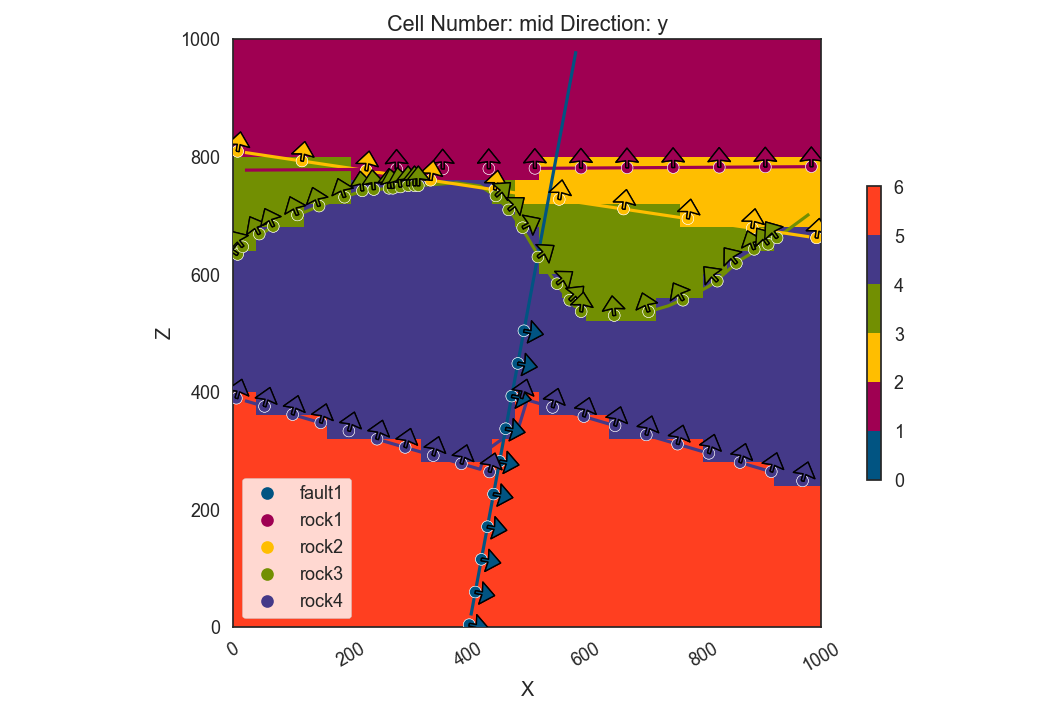

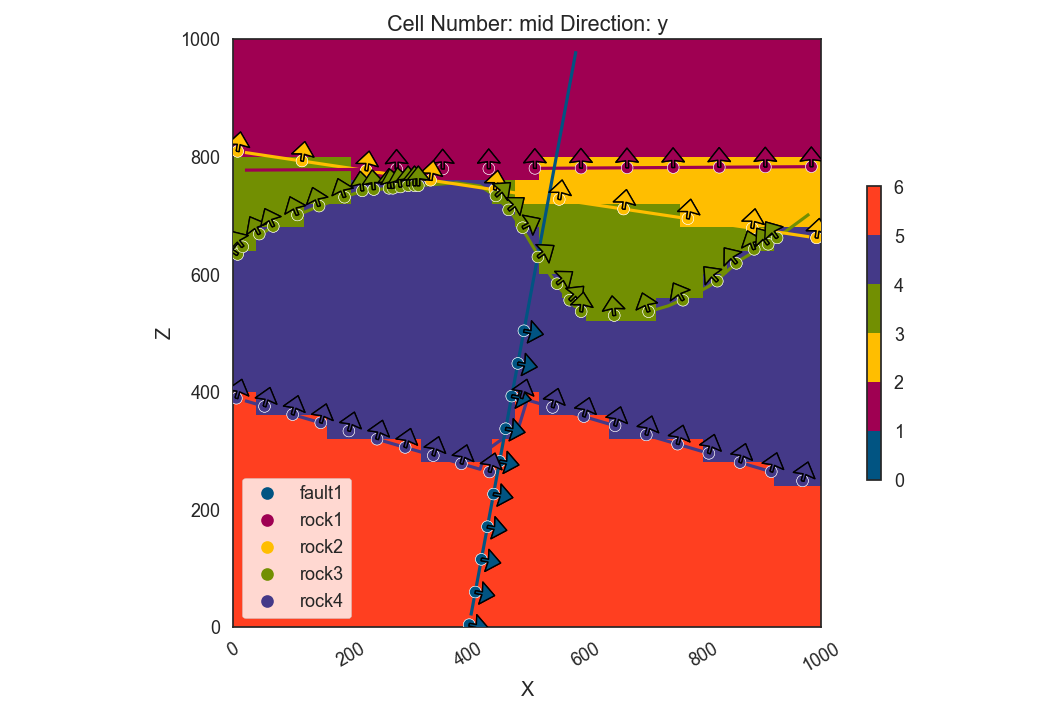

In [46]:
gpv.plot_2d(geo_model)

In [47]:
gpv.plot_3d(geo_model)